In [1]:
import time
from datetime import datetime
import pandas as pd
from prophet import Prophet

/Users/olestole/code/unibo/iot/air-quality-monitoring/backend/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

org = "olestole"
bucket = "air-quality"
token = "5_QgBT2jmMvNwnz9Ajet8_bAmeV_eXACmx3wJ-ATJ5oYnJLmHOeU5hA_9uwsYnF7Tm3no-iCCU1e0ipFLFKwrg=="
host = "18.170.70.157"
port = "8086"
url = f"http://{host}:{port}"

client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [3]:
client.health()

{'checks': [],
 'commit': 'a2f8538837',
 'message': 'ready for queries and writes',
 'name': 'influxdb',
 'status': 'pass',
 'version': 'v2.2.0'}

In [98]:
query = 'from(bucket:"air-quality")' \
        ' |> range(start:-24h)'\
        ' |> filter(fn: (r) => r["_measurement"] == "hum")' \
        ' |> filter(fn: (r) => r["_value"] != 0)' \
        ' |> aggregateWindow(every: 1m, fn: mean, createEmpty: false)'

In [99]:
result = client.query_api().query(org=org, query=query)

In [100]:
raw = []
for table in result:
    for record in table.records:
        raw.append((record.get_value(), record.get_time()))
print(raw[0:5])

[(44.26470588235294, datetime.datetime(2022, 5, 19, 9, 43, tzinfo=tzutc())), (44.26249975000001, datetime.datetime(2022, 5, 19, 9, 44, tzinfo=tzutc())), (43.60769207692307, datetime.datetime(2022, 5, 19, 10, 9, tzinfo=tzutc())), (43.62758555172414, datetime.datetime(2022, 5, 19, 10, 10, tzinfo=tzutc())), (43.386666766666686, datetime.datetime(2022, 5, 19, 10, 11, tzinfo=tzutc()))]


In [101]:
print("\n=== influxdb query into dataframe ===\n")
df=pd.DataFrame(raw, columns=['y','ds'], index=None)
df['ds'] = df['ds'].values.astype('<M8[s]')
df.set_index('ds')
df.head()


=== influxdb query into dataframe ===



,y,ds
0,44.264706,2022-05-19 09:43:00
1,44.262500,2022-05-19 09:44:00
2,43.607692,2022-05-19 10:09:00
3,43.627586,2022-05-19 10:10:00
4,43.386667,2022-05-19 10:11:00


In [102]:
df['y'] = df['y'].apply(lambda x: round(x, 2))

In [103]:
df.head()

,y,ds
0,44.26,2022-05-19 09:43:00
1,44.26,2022-05-19 09:44:00
2,43.61,2022-05-19 10:09:00
3,43.63,2022-05-19 10:10:00
4,43.39,2022-05-19 10:11:00


In [104]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.16482


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2684.62     0.0614071       1933.65           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2760.9     0.0187608       350.838      0.5418     0.05418      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2793.24    0.00150636       205.965      0.9014      0.9014      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       2798.25   2.65973e-05       96.4618   1.236e-07       0.001      494  LS failed, Hessian reset 
     399       2799.65    0.00175252       74.6266           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2803.99   0.000315701       232.798      0.6214      0.6214      7

In [105]:
future = m.make_future_dataframe(periods=50, freq='15T')
future[600:]

,ds
600,2022-05-20 03:31:00
601,2022-05-20 03:32:00
602,2022-05-20 03:33:00
603,2022-05-20 03:34:00
604,2022-05-20 03:35:00
...,...
916,2022-05-20 19:31:00
917,2022-05-20 19:46:00
918,2022-05-20 20:01:00
919,2022-05-20 20:16:00


In [106]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
916,2022-05-20 19:31:00,63.731350,18.212545,109.328271
917,2022-05-20 19:46:00,63.871078,16.774197,111.936667
918,2022-05-20 20:01:00,64.010806,15.022214,113.343213
919,2022-05-20 20:16:00,64.150533,13.572024,115.131221
920,2022-05-20 20:31:00,64.290261,11.923875,116.979358


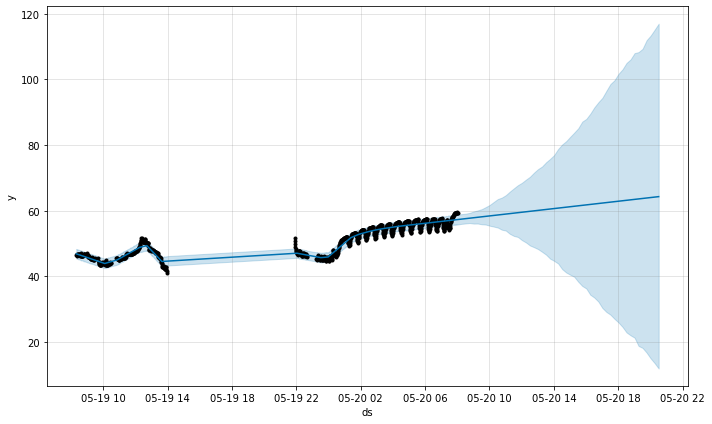

In [107]:
fig1 = m.plot(forecast)

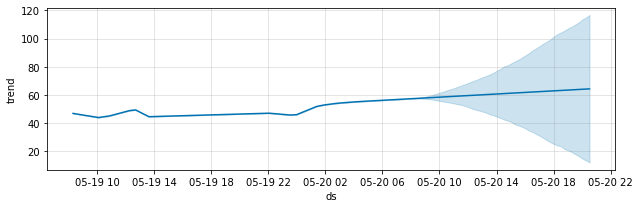

In [108]:
fig2 = m.plot_components(forecast)


In [109]:
forecast['measurement'] = "hum"

In [110]:
cp = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','measurement']].copy()
lines = [str(cp["measurement"][d]) 
         + ",type=forecast" 
         + " " 
         + "yhat=" + str(cp["yhat"][d]) + ","
         + "yhat_lower=" + str(cp["yhat_lower"][d]) + ","
         + "yhat_upper=" + str(cp["yhat_upper"][d])
         + " " + str(int(time.mktime(cp['ds'][d].timetuple()))) + "000000000" for d in range(len(cp))]

In [ ]:
lines